In [1]:
%matplotlib inline 

import rasterio
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


/d/pfournie/dl_toolbox/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from itertools import product

def get_tiles(nols, nrows, size, size2=None, step=None, step2=None, col_offset=0, row_offset=0, cover_all=True):
    
    if step is None: step = size
    if size2 is None: size2 = size
    if step2 is None: step2 = step

    max_col_offset = int(np.ceil((nols-size)/step))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    col_offsets = list(range(col_offset, col_offset + nols, step))[:max_col_offset+int(cover_all)]
    if cover_all:
        col_offsets[max_col_offset] = col_offset + nols - size

    max_row_offset = int(np.ceil((nrows-size2)/step2))
    # Remove all offsets such that offset+size > nols and add one offset to
    # reach nols
    row_offsets = list(range(row_offset, row_offset + nrows, step2))[:max_row_offset+int(cover_all)]
    if cover_all:
        row_offsets[max_row_offset] = row_offset + nrows - size2

    offsets = product(col_offsets, row_offsets)
    for col_off, row_off in offsets:
        yield rasterio.windows.Window(col_off=col_off, row_off=row_off, width=size, height=size2)

In [3]:
class MergeLabels:

    def __init__(self, labels, label_names=None):

        self.labels = labels

    def __call__(self, L):
        """
        If self.labels is [[0,1,2],[3,4,5]], then all pixels in classes [0,1,2]
        will be set to label 0 and all pixels in classes [3,4,5] will be set to
        label 1.
        :param L:
        :return:
        """
        ret = np.zeros(L.shape, dtype=L.dtype)
        for i, lab in enumerate(self.labels):
            for j in lab:
                ret[L == j] = i

        return ret

semcity_labels = {

    'base' : {
        'void': {'color': (255, 255, 255), 'count': 3080233},
        'impervious surface': {'color': (38, 38, 38), 'count': 45886967},
        'building': {'color': (238, 118, 33), 'count':43472320},
        'pervious surface': {'color': (34, 139, 34), 'count':58879144 },
        'high vegetation': {'color': (0, 222, 137), 'count':31261675 },
        'car': {'color': (255, 0, 0), 'count': 3753288},
        'water': {'color': (0, 0, 238), 'count': 7199301},
        'sport venue': {'color': (160, 30, 230), 'count': 0}
    },
    'semcity' : {
        'other': {'color': (255, 255, 255)},
        'pervious surface': {'color': (34, 139, 34)},
        'water': {'color': (0, 0, 238)},
        'building': {'color': (238, 118, 33)},
        'high vegetation': {'color': (0, 222, 137)},
        'impervious surface': {'color': (38, 38, 38)}
    },
    'building': {
        'background': {'color': (0,0,0)},
        'building': {'color': (255, 255, 255)}
    }
}

mergers = {
    'base' : [[0], [1], [2], [3], [4], [5], [6], [7]],
    'semcity' : [[0,7], [3], [6], [2], [4], [1, 5]],
    'building' : [[0,1,4,3,5,6,7],[2]]
}

In [16]:
class RasterDs(torch.utils.data.Dataset):

    def __init__(
        self,
        image_path,
        tile,
        crop_size,
        mins,
        maxs,
        img_aug=None,
        label_path=None,
        fixed_crops=False,
        crop_step=None
    ):

        self.image_path = image_path
        self.tile = tile
        self.mins = np.array(mins).reshape(-1, 1, 1)
        self.maxs = np.array(maxs).reshape(-1, 1, 1)
        self.crop_size = crop_size
        self.label_path = label_path
        
        with rasterio.open(image_path) as raster: 
            self.raster_tf = raster.transform
            
        if fixed_crops:
            self.fixed_crops = list(
                get_tiles(
                    nols=tile.width, 
                    nrows=tile.height, 
                    size=crop_size, 
                    step=crop_step if crop_step else crop_size,
                    row_offset=tile.row_off, 
                    col_offset=tile.col_off
                )
            )
        else:
            self.fixed_crops=None

    def __len__(self):

        return len(self.fixed_crops) if self.fixed_crops else 1 # Attention 1 ou la taille du dataset pour le concat

    def __getitem__(self, idx):
        
        if self.fixed_crops:
            crop = self.fixed_crops[idx]
        else:
            cx = self.tile.col_off + np.random.randint(0, self.tile.width - self.crop_size + 1)
            cy = self.tile.row_off + np.random.randint(0, self.tile.height - self.crop_size + 1)
            crop = rasterio.windows.Window(cx, cy, self.crop_size, self.crop_size)
                    
        image = self.read_image(self.image_path, crop)
        image = torch.from_numpy(image).float().contiguous()

        label = None
        if self.label_path:
            label = self.read_label(self.label_path, crop)
            label = torch.from_numpy(label).long().contiguous()

        return {
            'image':image,
            'label':label,
            'path': self.image_path
        }

def minmax(image, m, M):
    
    return np.clip((image - np.reshape(m, (-1, 1, 1))) / np.reshape(M - m, (-1, 1, 1)), 0, 1)

class Semcity(RasterDs):

    def __init__(self, labels, bands, *args, **kwargs):
        
        self.labels = semcity_labels[labels]
        self.bands = bands
        super().__init__(*args, **kwargs)
        self.label_merger = MergeLabels(mergers[labels])

    def read_image(self, image_path, window):

        with rasterio.open(image_path) as image_file:
            image = image_file.read(window=window, out_dtype=np.float32, indexes=self.bands)
            
        bands_idxs = np.array(self.bands) - 1
        image = minmax(image, self.mins[bands_idxs], self.maxs[bands_idxs])
            
        return image

    def read_label(self, label_path, window):
 
        with rasterio.open(label_path) as label_file:
            rgb = label_file.read(window=window, out_dtype=np.float32)
            
        rgb = rgb.transpose((1,2,0))
        labels = np.zeros(shape=rgb.shape[:-1], dtype=np.uint8)
        for label, key in enumerate(semcity_labels['base']):
            c = semcity_labels['base'][key]['color']
            d = rgb[..., 0] == c[0]
            d = np.logical_and(d, (rgb[..., 1] == c[1]))
            d = np.logical_and(d, (rgb[..., 2] == c[2]))
            labels[d] = label
        label = self.label_merger(labels)

        return label

torch.Size([512, 512])


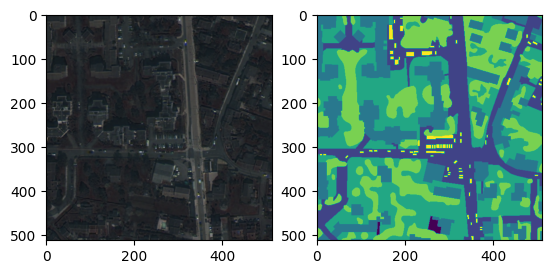

In [17]:
ds = Semcity(
    image_path='/data/SemCity-Toulouse-bench/img_multispec_05/TLS_BDSD_M/TLS_BDSD_M_01.tif',
    tile=rasterio.windows.Window(0,0,1000,1000),
    crop_size=512,
    mins=(125.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
    maxs=(1261.0, 1485.0, 2412.0, 3126.0, 2173.0, 3094.0, 2504.0, 2394.0),
    img_aug=None,
    label_path='/data/SemCity-Toulouse-bench/semantic_05/TLS_GT/TLS_GT_01_1.tif',
    fixed_crops=False,
    crop_step=None,
    labels='base',
    bands=[3,2,1]
)

item = ds[0]
print(item['image'][0].shape)

fig2, (ax2, ax3) = plt.subplots(1, 2)
ax2.imshow(item['image'].numpy().transpose(1,2,0)[...,:3])
ax3.imshow(item['label'].numpy())

ax2.autoscale_view()
ax3.autoscale_view()

In [19]:
from torch.utils.data import DataLoader, RandomSampler
from dl_toolbox.torch_collate import CustomCollate

trainset = Semcity(
    image_path='/data/SemCity-Toulouse-bench/img_multispec_05/TLS_BDSD_M/TLS_BDSD_M_01.tif',
    label_path='/data/SemCity-Toulouse-bench/semantic_05/TLS_GT/TLS_GT_01_1.tif',
    fixed_crops=False,
    mins=(125.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
    maxs=(1261.0, 1485.0, 2412.0, 3126.0, 2173.0, 3094.0, 2504.0, 2394.0),
    tile=rasterio.windows.Window(
        col_off=0,
        row_off=0,
        width=1000,
        height=1000
    ),
    crop_size=256,
    labels='base',
    bands=[3,2,1]
)

train_sampler = RandomSampler(
    data_source=trainset,
    replacement=True,
    num_samples=1000
)

train_dataloader = DataLoader(
    dataset=trainset,
    batch_size=8,
    drop_last=True,
    sampler=train_sampler,
    num_workers=2
)

test_set = Semcity(
    image_path='/data/SemCity-Toulouse-bench/img_multispec_05/TLS_BDSD_M/TLS_BDSD_M_01.tif',
    label_path='/data/SemCity-Toulouse-bench/semantic_05/TLS_GT/TLS_GT_01_1.tif',
    fixed_crops=True,
    mins=(125.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
    maxs=(1261.0, 1485.0, 2412.0, 3126.0, 2173.0, 3094.0, 2504.0, 2394.0),
    tile=rasterio.windows.Window(
        col_off=1000,
        row_off=0,
        width=1000,
        height=1000
    ),
    crop_size=256,
    labels='base',
    bands=[3,2,1]
)

test_dataloader = DataLoader(
    dataset=test_set,
    shuffle=False,
    batch_size=8,
    num_workers=2
)

dict_keys(['image', 'label', 'path'])


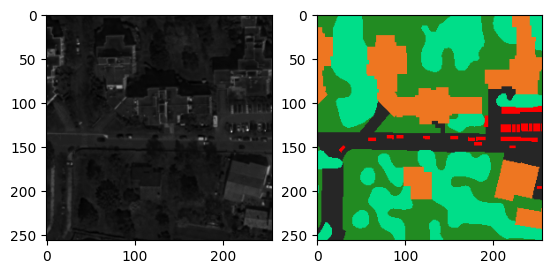

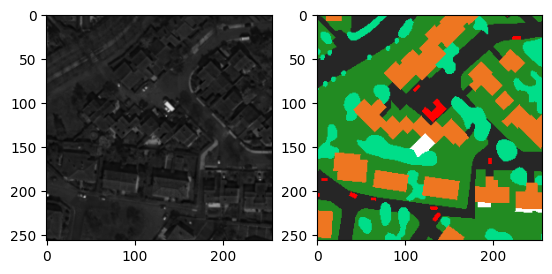

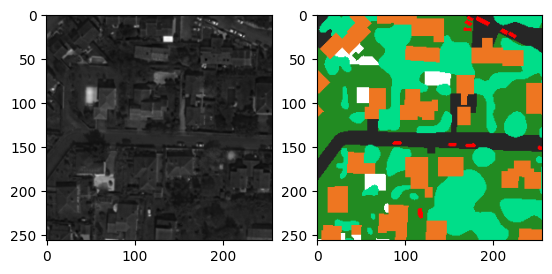

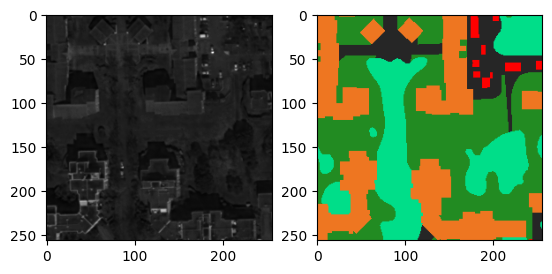

In [34]:
class LabelsToRGB:
    # Inputs shape : B,H,W or H,W
    # Outputs shape : B,H,W,3 or H,W,3

    def __init__(self, labels):

        self.labels = labels

    def __call__(self, labels):
        rgb = np.zeros(shape=(*labels.shape, 3), dtype=np.uint8)
        for label, key in enumerate(self.labels):
            mask = np.array(labels == label)
            rgb[mask] = np.array(self.labels[key]['color'])

        return rgb

labels_to_rgb = LabelsToRGB(semcity_labels['base'])

for i, batch in enumerate(train_dataloader):
    print(batch.keys())
    for j in range(4):
        f, ax = plt.subplots(ncols=2)
        imgs = batch['image']
        ax[0].imshow(batch['image'][j][0].numpy(), cmap='gray')
        ax[1].imshow(labels_to_rgb(batch['label'][j]))
    break


In [ ]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

device = 'cuda'

model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights=None,
    in_channels=3,
    classes=8,
    decoder_use_batchnorm=True
)

model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start_epoch = 0
columns = ['ep', 'train_loss', 'val_loss', 'time']

for epoch in range(start_epoch, 10):

    loss_sum = 0.0
    model.train()
    for batch in tqdm(train_dataloader):

        image = batch['image'].to(device)
        target = batch['label'].to(device)
        optimizer.zero_grad()
        logits = model(image)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()

    print('Train loss:', loss_sum / len(train_dataloader))
          
    loss_sum = 0.0
    model.eval()
    for batch in tqdm(test_dataloader):

        image = batch['image'].to(device)
        target = batch['label'].to(device)
        output = model(image)
        loss = loss_fn(output, target)
        loss_sum += loss.item()

    print('Test loss:', loss_sum / len(test_dataloader))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:10<00:00, 11.93it/s]


Train loss: 0.927505916595459


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.63it/s]


Test loss: 1.856901466846466


 54%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 67/125 [00:05<00:04, 12.23it/s]